# Identifying safe loans with decision trees 

In [1]:
#Libraries Import
import json
import string
import pydotplus
import numpy as np
import pandas as pd
from math import exp
from math import sqrt
from os import system
import matplotlib.pyplot as plt
from IPython.display import Image
pd.set_option("Chained_Assignment",None)
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier

In [2]:
#read dataframe
loans = pd.read_csv("lending-club-data.csv",low_memory=False)

In [3]:
#Exploring the target column

# safe_loans =  1 => safe
# safe_loans = -1 => risky

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
data=pd.crosstab(loans["safe_loans"],columns=["Percentage"]).apply(lambda r: (round((r/r.sum())*100,2)), axis=0).reset_index()
data

col_0,safe_loans,Percentage
0,-1,18.88
1,1,81.12


In [4]:
#Features for the classification algorithm
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [5]:
#Sample data to balance classes

safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print ("Number of safe loans  : %s" % len(safe_loans_raw))
print ("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


In [6]:
print ("Percentage of safe loans  :", round((len(safe_loans_raw)/(len(safe_loans_raw)+len(risky_loans_raw)))*100,2))
print ("Percentage of risky loans :", round((len(risky_loans_raw)/(len(safe_loans_raw)+len(risky_loans_raw)))*100,2))

Percentage of safe loans  : 81.12
Percentage of risky loans : 18.88


In [7]:
#creating dummy variables
col_cat_names=[]
[col_cat_names.append(x) for x,y in zip(loans.columns,loans.dtypes) if y==object]

for attr in col_cat_names:
    loans = loans.merge(pd.get_dummies(loans[attr], prefix=attr), left_index=True, right_index=True)
    loans.drop(attr,axis=1,inplace=True)

In [8]:
with open('module-5-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-5-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)    
    
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

In [9]:
Y = train_data['safe_loans'].values #target variable
X = train_data.drop('safe_loans', axis=1).values  #feature variable

In [10]:
decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(X, Y)

small_model = DecisionTreeClassifier(max_depth=2)
small_model = small_model.fit(X,Y)

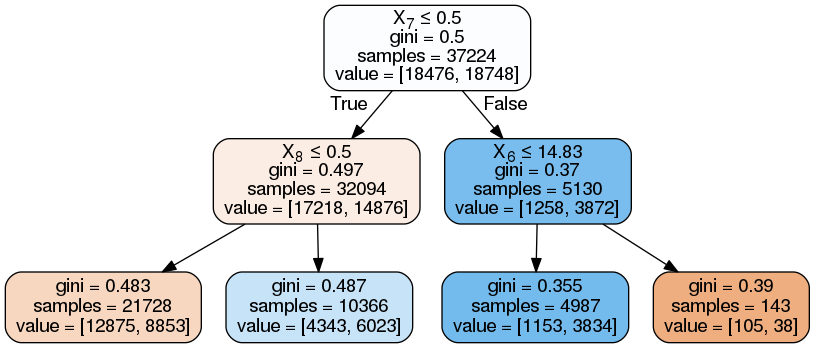

In [11]:
dot_data = StringIO()
export_graphviz(small_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [12]:
#Making predictions
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data


,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
sample_validation_data_Y = sample_validation_data['safe_loans'].values
sample_validation_data_X = sample_validation_data.drop('safe_loans', axis=1).values
print (sample_validation_data_Y.shape)
print (sample_validation_data_X.shape)

(4,)
(4, 67)


In [14]:
predictions=decision_tree_model.predict(sample_validation_data_X)

# QUIZ Identifying safe loans with decision trees

#### Question 1
What percentage of the predictions on sample_validation_data did decision_tree_model get correct?

__Ans__:

In [15]:
round(np.asarray(sample_validation_data_Y==predictions,dtype=int).sum()/len(sample_validation_data_Y)*100,2)

50.0

#### Question 2
Which loan has the highest probability of being classified as a safe loan?

__Ans__: 4

In [16]:
pd.DataFrame([x[1] for x in decision_tree_model.predict_proba(sample_validation_data_X)]).sort_values(0,ascending=False)

,0
3,0.792105
0,0.658435
1,0.463694
2,0.352490


#### Question 3
Notice that the probability preditions are the exact same for the 2nd and 3rd loans. Why would this happen?

In [17]:
pd.DataFrame([x[1] for x in small_model.predict_proba(sample_validation_data_X)]).sort_values(0,ascending=False)

,0
3,0.768799
0,0.581034
1,0.407447
2,0.407447


__Ans__: During tree traversal both examples fall into the same leaf node.

#### Question 4
Based on the visualized tree, what prediction would you make for this data point?

__Ans__: -1

In [18]:
small_model.predict(sample_validation_data.iloc[1].drop('safe_loans').values.reshape(1, -1))[0]

-1

#### Question 5
What is the accuracy of decision_tree_model on the validation set, rounded to the nearest .01 

In [19]:
Y = validation_data['safe_loans'].values #target variable
X = validation_data.drop('safe_loans', axis=1).values  #feature variable
predictions=decision_tree_model.predict(X)
round(np.asarray(Y==predictions,dtype=int).sum()/len(Y),2)

0.64

#### Question 6
How does the performance of big_model on the validation set compare to decision_tree_model on the validation set? Is this a sign of overfitting?

In [20]:
Y = train_data['safe_loans'].values #target variable
X = train_data.drop('safe_loans', axis=1).values  #feature variable
big_model=DecisionTreeClassifier(max_depth=10)
big_model = DecisionTreeClassifier(max_depth=10)
big_model = big_model.fit(X, Y)

In [21]:
big_model_predictions=big_model.predict(X)
print("Accuracy on training data")
print("Big Model: ",round(np.asarray(Y==big_model_predictions,dtype=int).sum()/len(Y),2))
Y = validation_data['safe_loans'].values #target variable
X = validation_data.drop('safe_loans', axis=1).values  #feature variable
big_model_predictions=big_model.predict(X)
decision_tree_model_predictions=decision_tree_model.predict(X)
print("Accuracy on validation data")
print("Big Model: ",round(np.asarray(Y==big_model_predictions,dtype=int).sum()/len(Y),2))
print("Decision Tree Model: ",round(np.asarray(Y==decision_tree_model_predictions,dtype=int).sum()/len(Y),2))


Accuracy on training data
Big Model:  0.66
Accuracy on validation data
Big Model:  0.63
Decision Tree Model:  0.64


__Ans__: big_model has lower accuracy on the validation set than decision_tree_model. This is overfitting.

#### Question 7
Let us assume that each mistake costs money:                         

Assume a cost of 10,000 per false negative.                                               
Assume a cost of 20,000 per false positive.                                                            
What is the total cost of mistakes made by decision_tree_model on validation_data? Please enter your answer as a plain integer, without the dollar sign or the comma separator, e.g. 3002000.

__False positives__ are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:
__False negatives__ are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [22]:
predictions=decision_tree_model.predict(X)
False_positives=np.asarray(((predictions==1)*(Y==-1)),dtype=int).sum()
False_negatives=np.asarray(((predictions==-1)*(Y==1)),dtype=int).sum()
cost=False_negatives*10000+False_positives*20000
print("Cost: ",cost)

Cost:  50390000
